### Imports

In [1]:
import pandas as pd
import streamlit as st
import numpy as np
import folium
import geopandas
import plotly.express as px
import seaborn as sns
from datetime import datetime
from matplotlib import pyplot as plt
from streamlit_folium import folium_static
from folium.plugins import MarkerCluster 
from operator import index
from statistics import mean 

In [2]:
st.set_page_config(layout='wide')

### Loading data

In [3]:
path = 'kc_house_data.csv'
data = pd.read_csv(path)

In [4]:
data.head()

,id,date,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,...,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15
0,7129300520,20141013T000000,221900.0,3,1.00,1180,5650,1.0,0,0,...,7,1180,0,1955,0,98178,47.5112,-122.257,1340,5650
1,6414100192,20141209T000000,538000.0,3,2.25,2570,7242,2.0,0,0,...,7,2170,400,1951,1991,98125,47.7210,-122.319,1690,7639
2,5631500400,20150225T000000,180000.0,2,1.00,770,10000,1.0,0,0,...,6,770,0,1933,0,98028,47.7379,-122.233,2720,8062
3,2487200875,20141209T000000,604000.0,4,3.00,1960,5000,1.0,0,0,...,7,1050,910,1965,0,98136,47.5208,-122.393,1360,5000
4,1954400510,20150218T000000,510000.0,3,2.00,1680,8080,1.0,0,0,...,8,1680,0,1987,0,98074,47.6168,-122.045,1800,7503


### Dropping duplicates and Outliers

In [5]:
data = data.drop_duplicates(subset='id', keep='last')
data = data[data['bedrooms'] != 33]
data.drop(columns=['sqft_living15','sqft_lot15'], inplace=True)

### Data Dimension

In [6]:
print('Number of rows: {}' .format (data.shape[0]))
print('Number of columns: {}' .format (data.shape[1]))

Number of rows: 21435
Number of columns: 19


### Set feature

In [7]:
data['date'] = pd.to_datetime( data['date'] ).dt.strftime( '%Y-%m-%d')
data['sqft_living'] = data['sqft_living'].apply(lambda x: x*0.09290304)
data['sqft_lot'] = data['sqft_lot'].apply(lambda x: x*0.09290304)
data['sqft_above'] = data['sqft_above'].apply(lambda x: x*0.09290304)
data['sqft_basement'] = data['sqft_basement'].apply(lambda x: x*0.09290304)
data['price_m2'] = data['price'] / data['sqft_lot']
data['month'] = pd.DatetimeIndex(data['date']).month
data['season'] = data['month'].apply(lambda x: 'autumn' if (x >=9 ) & (x <= 11) else
                                                'spring' if (x >=3 ) & (x <= 5) else
                                                'summer' if (x >=6 ) & (x <= 8) else
                                                'winter' )
data.rename(columns = {'sqft_living': 'm2_living','sqft_lot':'m2_lot','sqft_above':'m2_above','sqft_basement':'m2_basement'}, inplace=True) 

In [8]:
data.dtypes

id                int64
date             object
price           float64
bedrooms          int64
bathrooms       float64
m2_living       float64
m2_lot          float64
floors          float64
waterfront        int64
view              int64
condition         int64
grade             int64
m2_above        float64
m2_basement     float64
yr_built          int64
yr_renovated      int64
zipcode           int64
lat             float64
long            float64
price_m2        float64
month             int64
season           object
dtype: object

### Statistics Analysis

In [9]:
#Statistic Analysis
num_atributes = data.select_dtypes(include=['int64', 'float64'])
media = pd.DataFrame(num_atributes.apply(np.mean))
mediana = pd.DataFrame(num_atributes.apply(np.median))
std = pd.DataFrame(num_atributes.apply(np.std))
max_ = pd.DataFrame(num_atributes.apply(np.max))
min_ = pd.DataFrame(num_atributes.apply(np.min))

df1 = pd.concat([max_, min_, media, mediana, std], axis=1).reset_index()
df1.columns = ['atributes', 'max', 'min', 'media', 'median', 'std']

In [10]:
df1.head()

,atributes,max,min,media,median,std
0,id,9.900000e+09,1.000102e+06,4.580867e+09,3.904921e+09,2.876551e+09
1,price,7.700000e+06,7.500000e+04,5.416454e+05,4.500000e+05,3.673143e+05
2,bedrooms,1.100000e+01,0.000000e+00,3.370189e+00,3.000000e+00,9.068989e-01
3,bathrooms,8.000000e+00,0.000000e+00,2.117366e+00,2.250000e+00,7.699087e-01
4,m2_living,1.257907e+03,2.694188e+01,1.934916e+02,1.783738e+02,8.539100e+01


### Numerical Variables

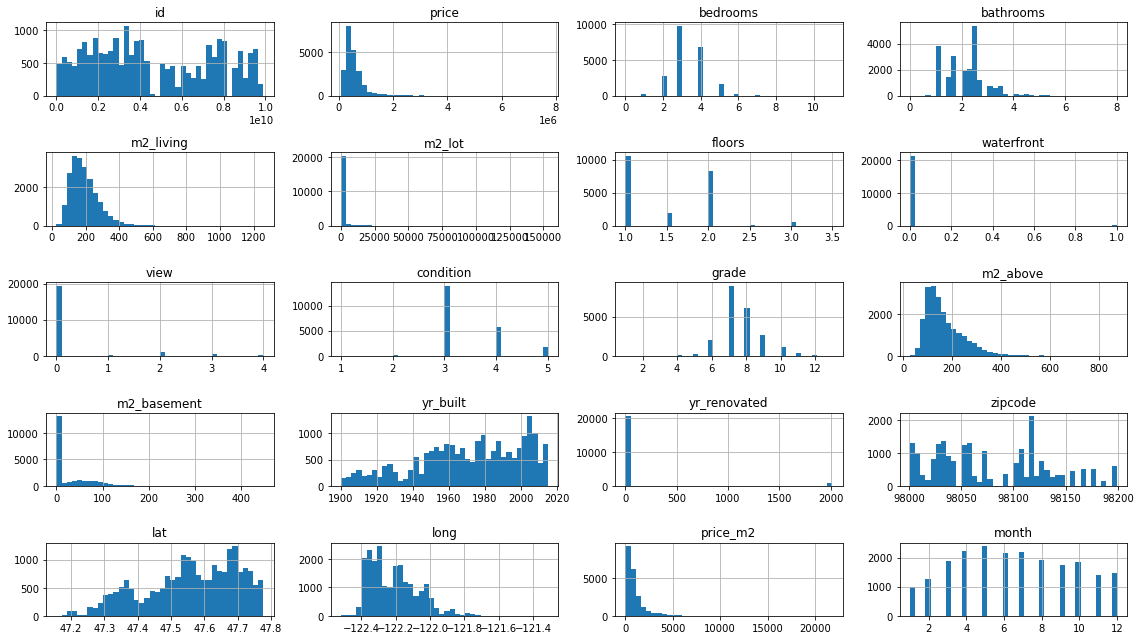

In [11]:
h1 = data.select_dtypes(include=['int64','float64'])
h1.hist(figsize=(16,9), bins=40)
plt.tight_layout()

### Averege Metrics per ZIPCODE

In [12]:
#Average Metrics
df1 = data[['id', 'zipcode']].groupby('zipcode').count().reset_index()
df2 = data[['price', 'zipcode']].groupby('zipcode').mean().reset_index()
df3 = data[['m2_living', 'zipcode']].groupby('zipcode').mean().reset_index()
df4 = data[['price_m2', 'zipcode']].groupby('zipcode').mean().reset_index()

#Merge
m1 = pd.merge(df1, df2, on='zipcode', how='inner')
m2 = pd.merge(m1, df3, on='zipcode', how='inner')
df = pd.merge(m2, df4, on='zipcode', how='inner')


In [13]:
df.head()

,zipcode,id,price,m2_living,price_m2
0,98001,359,2.818724e+05,177.007463,334.196596
1,98002,197,2.346067e+05,151.191916,402.662955
2,98003,276,2.958119e+05,179.436499,357.484627
3,98004,315,1.355387e+06,270.415680,1322.173815
4,98005,168,8.101649e+05,246.825128,655.721912


### Status: buy / not buy

In [14]:
df = data[['zipcode', 'price', 'season']].groupby(['zipcode']).median().reset_index().rename(columns ={'price': 'median_price'})
data= pd.merge( df, data, on='zipcode', how='inner')
data['status'] = data[['price', 'median_price', 'condition']].apply(lambda x: 1 if ((x['price'] <= x['median_price']) & (x['condition'] > 3))
                                                                                else 0 if (x['price'] > x['median_price']) 
                                                                                else 0 , axis=1)

In [15]:
df2 = data[(data['status'] == 1 )][['id', 'date', 'zipcode', 'price' , 'median_price','status', 'condition','season', 'lat', 'long',]].reset_index(drop=True)
value_saved = df2.apply(lambda x : x['median_price'] - x['price'], axis=1).sum()
value_total = df2['price'].sum()
print(f'Total investment amount.: {value_total:,.2f}')
print(f'Total amount saved: {value_saved:,.2f}')

Total investment amount.: 1,517,762,900.00
Total amount saved: 375,041,788.50


### Selling price suggestion

In [16]:
df3 = df2[['id', 'price', 'zipcode','season']].copy()
df_sell= df3[['price', 'zipcode','season']].groupby(['zipcode', 'season']).median().reset_index().rename(columns ={'price': 'median_price'})
df_sell = pd.merge(df3, df_sell, on=['zipcode', 'season'], how='inner')



df_sell['sugg_price'] = df_sell[['price', 'median_price']].apply(lambda x: (x['price']*1.3) if x['price'] < x['median_price']
                                                                                        else (x['price']*1.1), axis=1) 



df_sell['profit'] = df_sell['sugg_price'] - df_sell['price']


total_sell = df_sell['profit'].sum()
perc = ((df_sell['sugg_price'].sum()) - df_sell[ 'price'].sum()) / df_sell[ 'price'].sum()
#print(f'Total return over investment: {perc:.2%}')
print(f'Total value return: {total_sell:,.2f}')
    

Total value return: 277,465,277.80


In [17]:
df_sell

,id,price,zipcode,season,median_price,sugg_price,profit
0,9262800171,252000.0,98001,spring,212750.0,277200.0,25200.0
1,5402100045,189950.0,98001,spring,212750.0,246935.0,56985.0
2,5556800260,230000.0,98001,spring,212750.0,253000.0,23000.0
3,303000445,175000.0,98001,spring,212750.0,227500.0,52500.0
4,3750605349,210500.0,98001,spring,212750.0,273650.0,63150.0
...,...,...,...,...,...,...,...
3839,1370804461,565000.0,98199,spring,589000.0,734500.0,169500.0
3840,5037300130,672500.0,98199,spring,589000.0,739750.0,67250.0
3841,6821102385,334000.0,98199,spring,589000.0,434200.0,100200.0
3842,8127700210,600000.0,98199,spring,589000.0,660000.0,60000.0


### Profit by season

In [42]:
df4 = df_sell[['profit', 'season']].groupby(['season']).sum().reset_index()
df4

,season,profit
0,autumn,67185465.5
1,spring,76186013.7
2,summer,88931116.4
3,winter,45162682.2


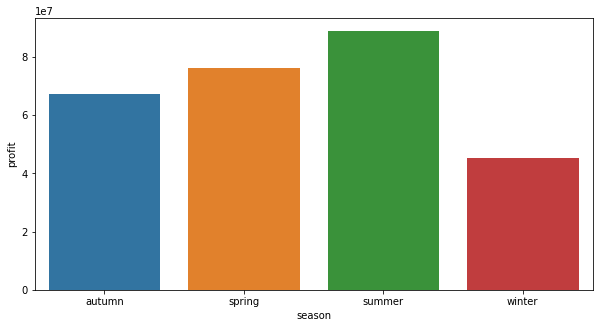

In [43]:
plt.figure(figsize=(10,5))
sns.barplot(data=df4, x='season', y='profit')
plt.show()

In [44]:
df_sell['profit'].sum()

277465277.8

### Total Profit

In [27]:
total_profit = total_sell + value_total
perc = (total_profit - value_total) / value_total
print(f'Total properties suggested to be purchased: {df2.shape[0]}')
print(f'Total investment amount: {value_total:,.2f}')
print(f'Total return over investment: {total_profit:,.2f}')
print(f'Total % return over investment: {perc:.2%}')

Total properties suggested to be purchased: 3844
Total investment amount: 1,517,762,900.00
Total return over investment: 1,795,228,177.80
Total % return over investment: 18.28%


### Hypothesis Analysis

##### H1: Properties with waterview are on average 50% more expensive.

H1: True. Properties with waterview are on average 211.76% more expensive.


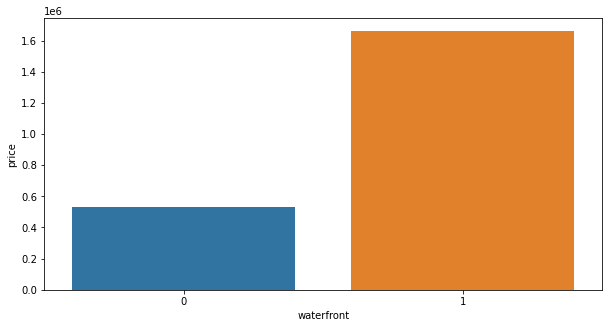

In [20]:
h1 = data[['price', 'waterfront']].groupby('waterfront').mean().reset_index()
perc = (h1.loc[1, 'price'] - h1.loc[0, 'price']) / h1.loc[0, 'price']
print(f'H1: True. Properties with waterview are on average {perc:.2%} more expensive.')

plt.figure(figsize=(10,5))
sns.barplot(data=h1, x='waterfront', y='price')
plt.show()


##### H2: Properties with basement are on average 20% more expensive.

H2: True. Properties with basement are on average 27.76% more expensive.


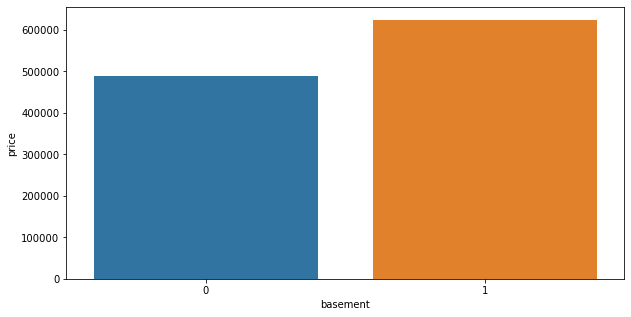

In [21]:
df_aux = data.copy()
df_aux['basement'] = df_aux['m2_basement'].apply(lambda x: 0 if x == 0 else 1)
h2 = df_aux[['price', 'basement']].groupby('basement').mean().reset_index()
perc = (h2.loc[1, 'price'] - h2.loc[0, 'price']) / h2.loc[0, 'price']
print(f'H2: True. Properties with basement are on average {perc:.2%} more expensive.')

plt.figure(figsize=(10,5))
sns.barplot(data=h2, x='basement', y='price')
plt.show()


##### H3: Properties built with basements decreased over the years.

H3: True. Properties built with basements decreased after 1980.


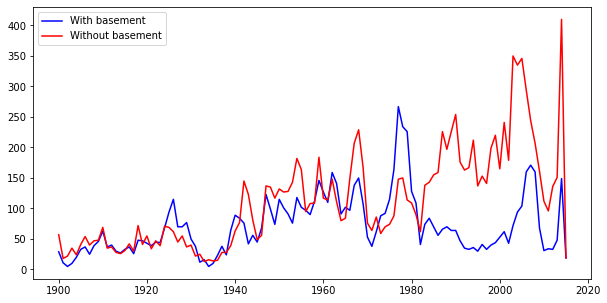

In [22]:
b1 = data[data['m2_basement']!=0][['m2_basement','yr_built']].groupby('yr_built').count().reset_index()
b2 = data[data['m2_basement']==0][['m2_basement','yr_built']].groupby('yr_built').count().reset_index()
h3 = pd.merge(b1, b2, on='yr_built', how='left').rename(columns={'m2_basement_x': 'with_basemement', 'm2_basement_y': 'without_basement'})
print('H3: True. Properties built with basements decreased after 1980.')

plt.figure(figsize=(10,5))
plt.plot(h3['yr_built'], h3['with_basemement'], color='blue', label='With basement')
plt.plot(h3['yr_built'], h3['without_basement'], color='red', label='Without basement')
plt.legend()
plt.show()

##### H4: Properties have bigger interior living space along construction year timeline.

H4: Properties have bigger interior living space incresead after 1940.


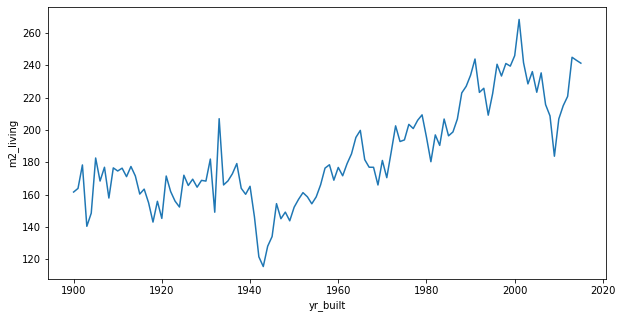

In [23]:
h4 = data[['m2_living', 'yr_built']].groupby('yr_built').mean().reset_index()
print('H4: Properties have bigger interior living space incresead after 1940.')
plt.figure(figsize=(10,5))
sns.lineplot(data=h4, x='yr_built', y='m2_living')
plt.show()

##### H5: Properties available during summer are more expensive.

H5: False. Properties available during spring are more expensive on average than other seasons.


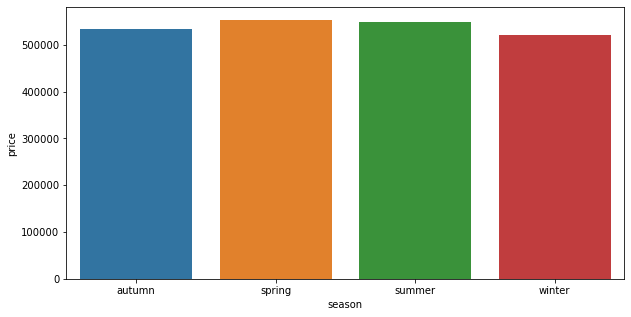

In [24]:
h5 = data[['season', 'price']].groupby('season').mean().reset_index()
print('H5: False. Properties available during spring are more expensive on average than other seasons.')
plt.figure(figsize=(10,5))
sns.barplot(data=h5, x='season', y='price')
plt.show()

##### H6: Properties that have not been renovated are 30% cheaper.

H6: True. Properties that have not been renovated are 43.29% more cheaper.


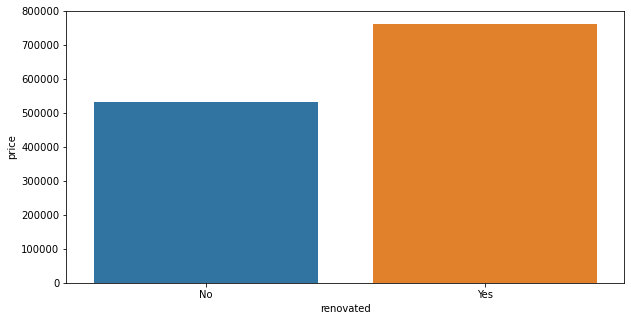

In [25]:
df_aux2 = data[['price', 'yr_renovated']].copy()
df_aux2['renovated'] = df_aux2.apply(lambda x: 'No' if x['yr_renovated']==0 else 'Yes', axis=1)
h6 = df_aux2[['price', 'renovated']].groupby('renovated').mean().reset_index()
perc = (h6.loc[1, 'price'] - h6.loc[0, 'price']) / h6.loc[0, 'price']
print(f'H6: True. Properties that have not been renovated are {perc:.2%} more cheaper.')
plt.figure(figsize=(10,5))
sns.barplot(data=h6, x='renovated', y='price')
plt.show()
